In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
def drop_id(ds):
    return ds.drop(columns='Id')


def drop_nans(train, threshold):
    new_train = train.copy()
    
    for feature in new_train.columns:
        nans = new_train[feature].isnull().sum()
        if (nans / train.shape[0] > threshold):
            new_train = new_train.drop(columns=feature)    
            
    return new_train


def replace_nans(train, method='ffill'):
    return train.copy().fillna(method=method)


def encode_features(train):
    new_train = train.copy()
    l_encoder = LabelEncoder()
    
    for feature in new_train.columns[:-1]:
        if (new_train[feature].dtype == 'object'):
            new_train[feature] = l_encoder.fit_transform(new_train[feature])
            
    return new_train

# Data preprocessing

In [3]:
# Нормировка
train = pd.read_csv('data/train.csv')

train = train.drop_duplicates()
train = drop_id(train)
train = drop_nans(train, threshold=0.2)
train = replace_nans(train)
print("nan count: ", train.isnull().sum().max())

train = encode_features(train)
train

nan count:  0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,3,0,0,0,...,272,0,0,0,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,0,0,0,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,3,3,0,4,0,...,0,0,0,0,0,8,2007,8,4,175000
1456,20,3,85.0,13175,1,3,3,0,4,0,...,0,0,0,0,0,2,2010,8,4,210000
1457,70,3,66.0,9042,1,3,3,0,4,0,...,0,0,0,0,2500,5,2010,8,4,266500
1458,20,3,68.0,9717,1,3,3,0,4,0,...,112,0,0,0,0,4,2010,8,4,142125


In [4]:
train['SalePrice'] = StandardScaler().fit_transform(np.log(train['SalePrice']).values[:, np.newaxis])
train['SalePrice'] = np.abs(np.min(train['SalePrice'])) + train['SalePrice']

<Figure size 1296x576 with 0 Axes>

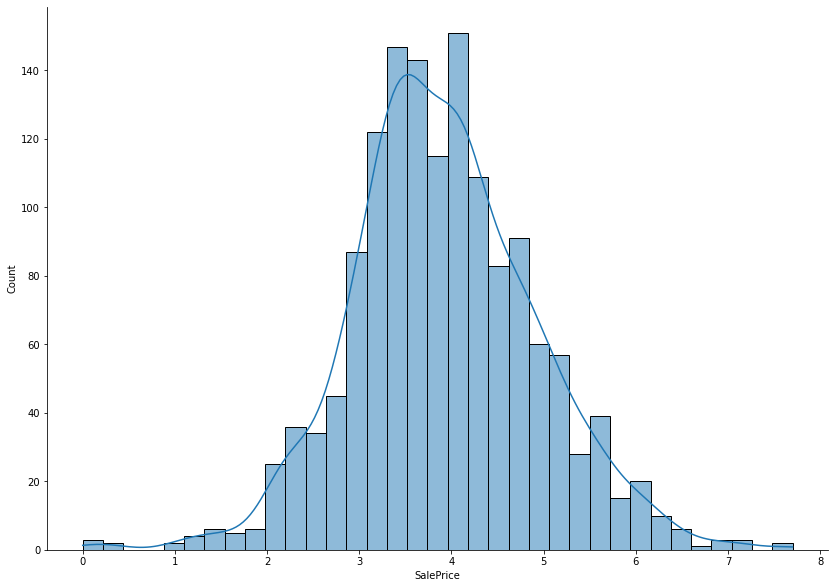

In [5]:
plt.figure(figsize=(18, 8))
sns.displot(train['SalePrice'], kde=True, height=8.27, aspect=11.7/8.27)

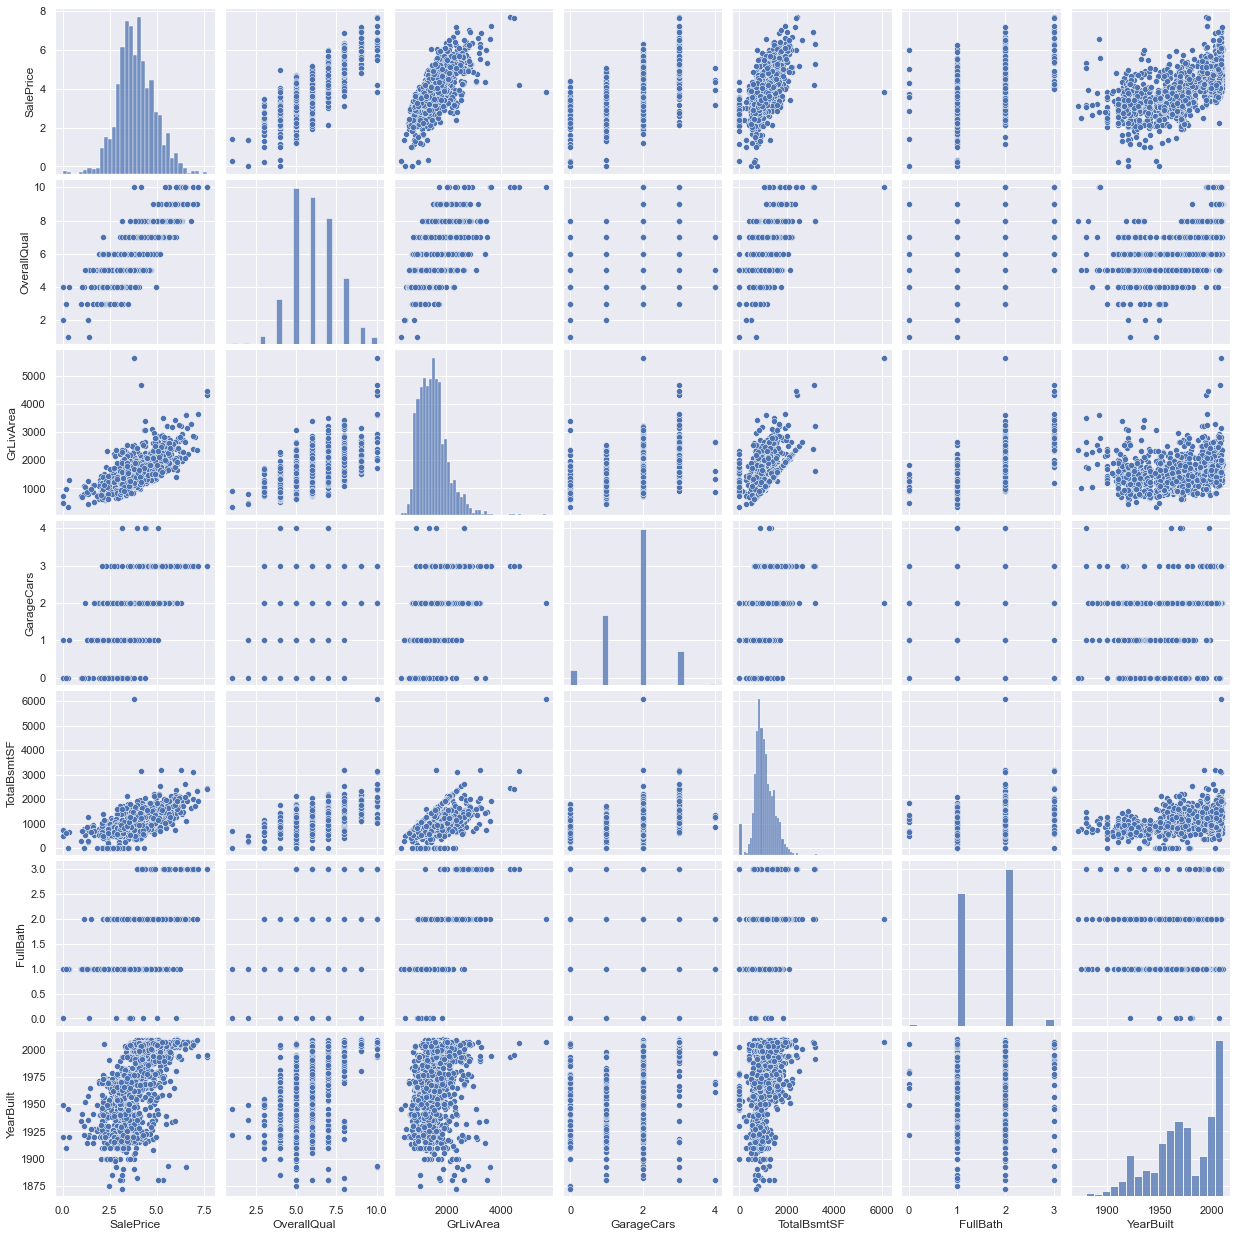

In [6]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show();

In [7]:
y_train = train['SalePrice'].values
x_train = train.drop(columns='SalePrice').values

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=98987)

# skilearn.RandomForest

In [8]:
# перебрать еще параметры, н-р кол-во деревьев
params = {
    "max_depth": randint(1, 3000),
    "n_estimators": randint(1, 5000),
    "min_samples_split":  randint(1, 15)
}

model = RandomForestRegressor()
gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train[:400], y_train[:400])
print(f"best params: {gs_model.best_params_}")

best params: {'max_depth': 280, 'min_samples_split': 3, 'n_estimators': 3702}


In [9]:
model = RandomForestRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
print("mean_squared_log_error: ", np.sqrt(metrics.mean_squared_log_error(model.predict(X_test), y_test)))

mean_squared_log_error:  0.13550569630027925


# XGBoost

In [10]:
# побольше параметров + random search
params = {
    "learning_rate": uniform(1e-3,  1e-1),
    "max_depth": randint(1, 100),
    "min_child_weight": randint(1, 15),
    "n_estimators": randint(1, 1000),
    "colsample_bytree": uniform(1e-1,  1)
}

model = XGBRegressor()
gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train[:400], y_train[:400])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'colsample_bytree': 0.2214599230779958, 'learning_rate': 0.05604202813063902, 'max_depth': 76, 'min_child_weight': 9, 'n_estimators': 97}


In [11]:
model = XGBRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
print("mean_squared_log_error: ", np.sqrt(metrics.mean_squared_log_error(model.predict(X_test), y_test)))

mean_squared_log_error:  0.12898411433214854


# catboost

In [12]:
model = CatBoostRegressor(logging_level='Silent')

params = {
    "n_estimators": randint(1, 400),
    "learning_rate": uniform(1e-3,  1e-1),
    "depth": randint(1, 15)
}

gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train[:400], y_train[:400])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'depth': 2, 'learning_rate': 0.08208667352706371, 'n_estimators': 341}


In [13]:
model = CatBoostRegressor(**gs_model.best_params_, logging_level='Silent')
model.fit(X_train, y_train)
print("mean_squared_log_error: ", np.sqrt(metrics.mean_squared_log_error(model.predict(X_test), y_test)))

mean_squared_log_error:  0.1170419364303354


# lightgbm

In [14]:
model = LGBMRegressor()

params = {
    'num_leaves': randint(1, 3000),
    'learning_rate': uniform(1e-3,  1e-1),
    'max_depth': randint(1, 3000),
    'n_estimators': randint(1, 5000)
}

gs_model = RandomizedSearchCV(model, params, n_jobs=-1, cv=3)
gs_model.fit(X_train[:400], y_train[:400])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'learning_rate': 0.03274496527841586, 'max_depth': 1136, 'n_estimators': 970, 'num_leaves': 1082}


In [15]:
model = LGBMRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
print("mean_squared_log_error: ", np.sqrt(metrics.mean_squared_log_error(model.predict(X_test), y_test)))

mean_squared_log_error:  0.1255514338687133
